# Training
This notebook trains the model with 3 fold cross validation.

In [1]:
from codecarbon import EmissionsTracker
import logging
output_directory = "/fp/homes01/u01/ec-krimhau/thesis_code/"

tracker = EmissionsTracker(output_dir=output_directory)
tracker.start()

[codecarbon INFO @ 06:38:38] [setup] RAM Tracking...
[codecarbon INFO @ 06:38:38] [setup] GPU Tracking...
[codecarbon INFO @ 06:38:38] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 06:38:38] [setup] CPU Tracking...
[codecarbon WARNING @ 06:38:38] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 06:38:39] We saw that you have a AMD EPYC 7452 32-Core Processor but we don't know it. Please contact us.
[codecarbon INFO @ 06:38:39] CPU Model on constant consumption mode: AMD EPYC 7452 32-Core Processor
[codecarbon INFO @ 06:38:39] >>> Tracker's metadata:
[codecarbon INFO @ 06:38:39]   Platform system: Linux-5.14.0-284.30.1.el9_2.x86_64-x86_64-with-glibc2.34
[codecarbon INFO @ 06:38:39]   Python version: 3.11.3
[codecarbon INFO @ 06:38:39]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 06:38:39]   Available RAM : 64.000 GB
[codecarbon INFO @ 06:38:39]   CPU count: 24
[codecarbon INFO @ 06:38:39]   CPU model: AMD EPYC 7452 32-Core Processor
[codecarbon 

In [2]:
logging.getLogger('codecarbon').setLevel(logging.WARNING)

# Imports and setup

In [3]:
import sys
# Need this to load the packages correc in Fox ml nodes.
sys.path.append("/fp/homes01/u01/ec-krimhau/.local/lib/python3.11/site-packages")

In [4]:
import os
import gc
import copy
import time
import random
import string
import joblib

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Utils
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold

# For Transformer Models
from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW
from transformers import DataCollatorWithPadding
import datasets
# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import wandb

In [5]:
# Load .env file
%load_ext dotenv
%dotenv /fp/homes01/u01/ec-krimhau/thesis_code/.env

In [6]:
# Get wandb api key from .env file
wandb_api_key = os.getenv('WANDB_API_KEY')
# Login to wandb to track results
wandb.login(key = wandb_api_key) # API key

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: haugerud-kristian (krimhau). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /fp/homes01/u01/ec-krimhau/.netrc


True

In [7]:
# Function to generate a unique random identifier for experiment tracking.
def id_generator(size=12, chars=string.ascii_lowercase + string.digits):
    return ''.join(random.SystemRandom().choice(chars) for _ in range(size))


HASH_NAME = "05wyh68d15r6"
print(HASH_NAME)

05wyh68d15r6


In [8]:
# Config for the model
CONFIG = {"seed": 42,
          "epochs": 3,
          "model_name": "microsoft/deberta-v3-base",
          "train_batch_size": 8,
          "valid_batch_size": 16,
          "max_length": 512,
          "learning_rate": 1e-5,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 3,
          "n_accumulate": 1,
          "num_classes": 2,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          "hash_name": HASH_NAME,
          "_wandb_kernel": "deb",
          }

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])
CONFIG['group'] = f'{HASH_NAME}-Baseline'


In [9]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [10]:
# Splits the data into train and test. Validation is done using KFold.
def train_test_split(df, train_percent=.85, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    train = df.iloc[perm[:train_end]]
    test = df.iloc[perm[train_end:]]
    return train, test

In [11]:
!ls /fp/projects01/ec307/ec-krimhau/jira_datasets

highest_high_vs_low_lowest_balanced_jira.csv	high_vs_rest
highest_vs_lowest_balanced_jira.csv		jira_clean_with_all_cols.csv
highest_vs_rest_balanced_jira.csv		jira_highest_high_vs_low_lowest
highest_vs_rest_min_len_25th_balanced_jira.csv	jira_highest_vs_lowest
high_highest_vs_rest				testsets_clean


In [12]:
path_name = "/fp/projects01/ec307/ec-krimhau/jira_datasets"
file_name = "highest_high_vs_low_lowest_balanced_jira.csv"

In [13]:
import pandas as pd
priority_df = pd.read_csv(f"{path_name}/{file_name}")
priority_df

,label,text
0,1,we need to bump the version to example image e...
1,1,right now it is almost impossible to create se...
2,0,this is a followup of which contained two issu...
3,1,create a maven assembly to produce a zip file ...
4,0,suggestion slack bot that runs upstream should...
...,...,...
273519,1,noformatnopaneltrueexternalstestspy fileextern...
273520,0,when you browse the mbeans in jconsole both ac...
273521,1,after creating new instance from bare karaf in...
273522,0,im writing a method which is not existing yet ...


In [14]:
priority_df['label'].value_counts()

label
1    136762
0    136762
Name: count, dtype: int64

In [15]:
priority_df.isna().any().any()

False

In [16]:
train_hp_df , test_hp_df = train_test_split(priority_df)

In [17]:
df = train_hp_df

In [18]:
df.reset_index(inplace = True)

In [19]:
df.drop(columns=["index"], inplace=True)

In [20]:
df

,label,text
0,1,if an assessment contains an audio recording q...
1,0,click on student view tab the blue info box an...
2,0,after the start of trafodion the log filenames...
3,1,im getting eof reached before python server ac...
4,1,str deploy cluster try to add a new host only ...
...,...,...
232490,1,the filename in jpa changelog is invalidis be
232491,1,commonls chukwahomelibjar chukwahomehadoopjars...
232492,1,this is the sequence of default executor launc...
232493,1,after upgrading our app from to we got several...


In [21]:
gkf = GroupKFold(n_splits=CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(gkf.split(X=df, groups=df.text)):
    df.loc[val_ , "kfold"] = int(fold)
    
df["kfold"] = df["kfold"].astype(int)


In [22]:
df.groupby('kfold')['label'].value_counts()


kfold  label
0      0        39268
       1        38231
1      1        38976
       0        38522
2      1        39131
       0        38367
Name: count, dtype: int64

In [23]:
df

,label,text,kfold
0,1,if an assessment contains an audio recording q...,1
1,0,click on student view tab the blue info box an...,2
2,0,after the start of trafodion the log filenames...,2
3,1,im getting eof reached before python server ac...,1
4,1,str deploy cluster try to add a new host only ...,0
...,...,...,...
232490,1,the filename in jpa changelog is invalidis be,2
232491,1,commonls chukwahomelibjar chukwahomehadoopjars...,1
232492,1,this is the sequence of default executor launc...,0
232493,1,after upgrading our app from to we got several...,1


In [24]:
class HP_Dataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        self.targets = df['label'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        return {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'target': self.targets[index]
        }

In [25]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])


In [26]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [27]:
class HP_Model(nn.Module):
    def __init__(self, model_name):
        super(HP_Model, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.config = AutoConfig.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.pooler = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.pooler(out.last_hidden_state, mask)
        out = self.drop(out)
        outputs = self.fc(out)
        return outputs

In [28]:
def criterion(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

In [29]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        loss = loss / CONFIG['n_accumulate']
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score



In [31]:
def all_classification_report(y_true, y_pred, target_names = ['Non_HP', 'HP'], digits=4):
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names = target_names, digits=4))
    
    accuracy =round(accuracy_score(y_true, y_pred),4)
    print("Accuracy =",  accuracy)
    f1score = round(f1_score(y_true, y_pred),4)
    print("F1_score =", f1score)

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Non_HP', 'HP'])
    ax.yaxis.set_ticklabels(['Non_HP', 'HP'])
    
    return  accuracy , f1score
    
    

In [32]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    dataset_size = 0
    running_loss = 0.0
    
    y_pred = []
    y_true = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        

        predictions = torch.argmax(outputs, dim=-1).flatten().tolist()
        
        target = targets.tolist()

        y_pred.extend(predictions)
        y_true.extend(target)
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,LR=optimizer.param_groups[0]['lr'])   
    
    
    accuracy, f1score = all_classification_report(y_true,y_pred)
    gc.collect()
    
    return epoch_loss , accuracy , f1score

In [33]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, accuracy , f1score = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
      
        history['Valid accuracy'].append(accuracy)
        history['Valid f1score'].append(f1score)



        
        # Log the metrics
        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Valid Loss": val_epoch_loss})
        wandb.log({"Valid Accuracy": accuracy})
        wandb.log({"Valid F1_score": f1score})


        
        # deep copy the model
        if val_epoch_loss <= best_epoch_loss:
            print(f"{b_}Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            run.summary["Best Loss"] = best_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"{HASH_NAME}-Loss-Fold-{fold}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history


In [34]:
def prepare_loaders(fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = HP_Dataset(df_train, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])
    valid_dataset = HP_Dataset(df_valid, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], collate_fn=collate_fn, 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], collate_fn=collate_fn,
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [35]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

<h2> Testing Inference </h2>


In [36]:
import warnings,transformers,logging,torch

warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [37]:
test_df = test_hp_df

In [38]:
test_df

,label,text
230243,0,to give a pool the correct size it is mandator...
49775,0,repositoryinterfaceawarebeanpostprocessorpredi...
58433,0,when trying to use the backslashbackslash esca...
159647,1,i am writing a decoder to decode and print out...
26430,0,steps to open the html file in the attached zi...
...,...,...
119879,0,the defaultparameterparser does not decode car...
259178,0,new hybrid mobile projects should support temp...
131932,0,consider the following query codesql select fr...
146867,1,hiin our multimodules project we have added a ...


In [39]:
class HP_TestDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        samples = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            
        }

        if 'token_type_ids' in inputs:
            samples['token_type_ids'] = inputs['token_type_ids']
        
        return samples

In [40]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])

softmax = nn.Softmax(dim=1)
model = HP_Model(CONFIG['model_name'])

In [41]:
def prepare_test_loader(test_df):    
    test_dataset = HP_TestDataset(test_df, 
                                   tokenizer=CONFIG['tokenizer'], 
                                   max_length=CONFIG['max_length'])
    
    test_loader = DataLoader(test_dataset, 
                             batch_size=CONFIG['valid_batch_size'], 
                             collate_fn=collate_fn, 
                             num_workers=2, 
                             shuffle=False, 
                             pin_memory=True, 
                             drop_last=False)
    return test_loader

test_loader = prepare_test_loader(test_df)

In [42]:
@torch.no_grad()
def inference(test_loader, model, device):
    preds = []
    preds_target = []
    model.eval()
    model.to(device)
    
    bar = tqdm(enumerate(test_loader), total=len(test_loader))
    
    for step, data in bar: 
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        
        output = model(ids, mask)
        y_preds = softmax(torch.tensor(output.to('cpu'))).numpy()
        pred_target = torch.argmax(output, dim=-1).flatten().tolist()
        
        preds.append(y_preds)
        preds_target.append(pred_target) 
    predictions = np.concatenate(preds)
    predictions_label = np.concatenate(preds_target)
    return predictions , predictions_label

In [43]:
deberta_predictions = []
deberta_predictions_labels = []



for fold in range(0, CONFIG['n_fold']):
    print("Fold {}".format(fold))
    
    state = torch.load(f'{HASH_NAME}-Loss-Fold-{fold}.bin')
    model.load_state_dict(state)
    
    prediction, predictions_label = inference(test_loader, model, CONFIG['device'])
    deberta_predictions.append(prediction)
    deberta_predictions_labels.append(predictions_label)
    del state, prediction; gc.collect()
    torch.cuda.empty_cache()
del model

Fold 0


100%|██████████| 2565/2565 [05:31<00:00,  7.74it/s]


Fold 1


100%|██████████| 2565/2565 [05:31<00:00,  7.75it/s]


Fold 2


100%|██████████| 2565/2565 [05:31<00:00,  7.75it/s]


In [44]:
deberta_predictions


[array([[0.6421475 , 0.35785255],
        [0.9346304 , 0.06536961],
        [0.51164633, 0.4883537 ],
        ...,
        [0.48352957, 0.5164704 ],
        [0.57484627, 0.42515373],
        [0.23657575, 0.7634243 ]], dtype=float32),
 array([[0.71826375, 0.28173622],
        [0.92294353, 0.07705648],
        [0.7317419 , 0.2682581 ],
        ...,
        [0.13836133, 0.86163867],
        [0.2925457 , 0.70745426],
        [0.02743321, 0.9725667 ]], dtype=float32),
 array([[0.5754708 , 0.4245292 ],
        [0.8921012 , 0.10789876],
        [0.49810943, 0.50189054],
        ...,
        [0.24139804, 0.758602  ],
        [0.35691035, 0.64308965],
        [0.16152562, 0.83847445]], dtype=float32)]

In [45]:
predictions = np.mean(deberta_predictions, axis=0)
predictions

array([[0.645294  , 0.35470596],
       [0.91655844, 0.08344162],
       [0.58049923, 0.4195008 ],
       ...,
       [0.28776297, 0.71223706],
       [0.40810075, 0.5918992 ],
       [0.14184487, 0.8581552 ]], dtype=float32)

In [46]:
len(predictions)

41029

In [47]:
predictions

array([[0.645294  , 0.35470596],
       [0.91655844, 0.08344162],
       [0.58049923, 0.4195008 ],
       ...,
       [0.28776297, 0.71223706],
       [0.40810075, 0.5918992 ],
       [0.14184487, 0.8581552 ]], dtype=float32)

In [48]:
test_df["prediction_0"] = predictions[:, 0] 

In [49]:
test_df["prediction_1"] = predictions[:, 1] 

In [50]:
for i in range(0, CONFIG['n_fold']):

    test_df[f"prediction_label_fold_{i}"] = deberta_predictions_labels[i]


In [51]:
test_df

,label,text,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2
230243,0,to give a pool the correct size it is mandator...,0.645294,0.354706,0,0,0
49775,0,repositoryinterfaceawarebeanpostprocessorpredi...,0.916558,0.083442,0,0,0
58433,0,when trying to use the backslashbackslash esca...,0.580499,0.419501,0,0,1
159647,1,i am writing a decoder to decode and print out...,0.752685,0.247315,0,0,0
26430,0,steps to open the html file in the attached zi...,0.573262,0.426738,0,0,0
...,...,...,...,...,...,...,...
119879,0,the defaultparameterparser does not decode car...,0.805808,0.194192,0,0,0
259178,0,new hybrid mobile projects should support temp...,0.357233,0.642767,1,1,1
131932,0,consider the following query codesql select fr...,0.287763,0.712237,1,1,1
146867,1,hiin our multimodules project we have added a ...,0.408101,0.591899,0,1,1


In [52]:
len(test_df)

41029

In [53]:
test_df['Max'] = test_df[['prediction_0','prediction_1']].idxmax(axis=1)

In [54]:
test_df["pred"] = test_df['Max'].apply(lambda x: x.replace("prediction_0", "0"))

In [55]:
test_df["pred"] = test_df['pred'].apply(lambda x: x.replace("prediction_1", "1"))


In [56]:
test_df["pred"] = test_df["pred"].astype(int)

In [57]:
test_df

,label,text,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2,Max,pred
230243,0,to give a pool the correct size it is mandator...,0.645294,0.354706,0,0,0,prediction_0,0
49775,0,repositoryinterfaceawarebeanpostprocessorpredi...,0.916558,0.083442,0,0,0,prediction_0,0
58433,0,when trying to use the backslashbackslash esca...,0.580499,0.419501,0,0,1,prediction_0,0
159647,1,i am writing a decoder to decode and print out...,0.752685,0.247315,0,0,0,prediction_0,0
26430,0,steps to open the html file in the attached zi...,0.573262,0.426738,0,0,0,prediction_0,0
...,...,...,...,...,...,...,...,...,...
119879,0,the defaultparameterparser does not decode car...,0.805808,0.194192,0,0,0,prediction_0,0
259178,0,new hybrid mobile projects should support temp...,0.357233,0.642767,1,1,1,prediction_1,1
131932,0,consider the following query codesql select fr...,0.287763,0.712237,1,1,1,prediction_1,1
146867,1,hiin our multimodules project we have added a ...,0.408101,0.591899,0,1,1,prediction_1,1


In [58]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_df["label"].values, test_df["pred"].values)

print(cf_matrix)

[[15443  5162]
 [ 4203 16221]]


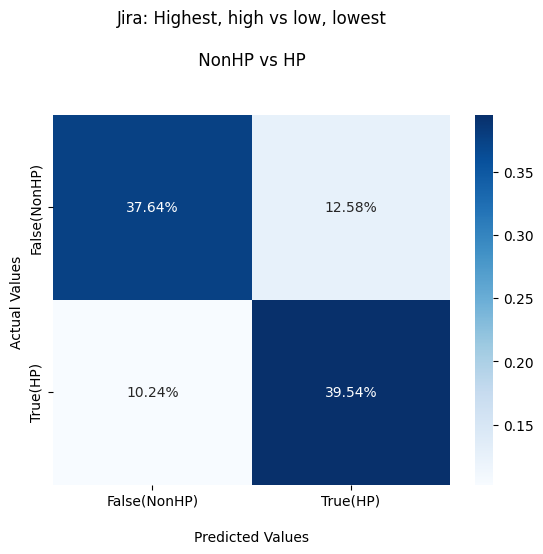

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Jira: Highest, high vs low, lowest\n\n NonHP vs HP \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False(NonHP)','True(HP)'])
ax.yaxis.set_ticklabels(['False(NonHP)','True(HP)'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [60]:
from sklearn.metrics import classification_report


print(classification_report(test_df["label"].values, test_df["pred"].values))

              precision    recall  f1-score   support

           0       0.79      0.75      0.77     20605
           1       0.76      0.79      0.78     20424

    accuracy                           0.77     41029
   macro avg       0.77      0.77      0.77     41029
weighted avg       0.77      0.77      0.77     41029



In [61]:
from sklearn.metrics import matthews_corrcoef

# Calculate the Matthew's Correlation Coefficient
mcc = matthews_corrcoef(test_df["label"].values, test_df["pred"].values)
print("Matthew's Correlation Coefficient:", mcc)

Matthew's Correlation Coefficient: 0.5441735701814994


In [62]:
tracker.stop()

0.003173624291332565